In [5]:
from sklearn.mixture import BayesianGaussianMixture
from fastdtw import fastdtw
import numpy as np
from rich import print
import pandas as pd
import holoviews as hv
from functools import partial
import glob


In [21]:
def load_list():
    files = glob.glob("Recording*.csv")
    print(f"Loading {files}")
    recordings = [pd.read_csv(f) for f in files]
    for r in recordings:
        r["ts"] = pd.to_datetime(r["ts"], unit="s")
    return recordings

def calc_angle_mags(ar: np.array):
    Fxt = ar[0]
    Fyt = ar[1]
    Fzt = ar[2]
    mag = np.sqrt(Fxt**2 + Fyt**2)
    ang = (np.pi / 2.0) - np.arctan2(Fxt / mag, Fyt / mag)
    return ang, mag


def calc_x_y(F: np.array):
    x1 = 0.38
    x2 = 0.38  #  + 0.05
    h = 0.01
    # y = x1/2 * ( (F1z + F2z - F3z - F4z) + h*(F1y + F2y + F3y + F4y) ) / (F1z + F2z + F3z + F4z)
    # x = x2/2 * ( (F1z - F2z - F3z + F4z) + h*(F1x + F2x + F3x + F4x) ) / (F1z + F2z + F3z + F4z)
    # F.shape: [4,7] < SensorNo, <ts,x,y,z,mx,my,mz> >
    ze = 2
    Fxt, Fyt, Fzt = [np.sum(F[:, i]) for i in range(0, 3)]

    # print(Fxt, Fyt, Fzt)

    y = 1 / Fzt * (h * Fyt + x1 / 2 * (F[0:2, ze].sum() - F[2:, ze].sum()))
    x = 1 / Fzt * (h * Fxt + (x2 / 2) * (F[0::3, ze].sum() - F[1:3, ze].sum()))
    ang, mag = calc_angle_mags(np.array([Fxt, Fyt, Fzt]))

    return np.array(
        [
            x + x2 / 2,
            y + x1 / 2,
            np.linalg.norm([Fxt, Fyt, Fzt]),
            ang,
            mag,
            Fxt,
            Fyt,
            Fzt,
        ]
    )

def cut_off_dfs(dfd: dict):
    """cuts off the dataframes in a dict to the shortest one"""
    # TODO values need to be sorted
    min_len = min([df.shape[0] for df in dfd.values()])
    return {key: dfd[key][-min_len:, :] for key in dfd.keys()}


def augment_data(data):
    """This seperates out one dataframe into several numpy arrays as dict according to the column 'name'
    Also synchronizes the length by cutting longer dataframes

    Args:
        data (DataFrame): dataframe with column name

    Returns:
        dict: dict with numpy arrays
    """
    names = data["name"].unique()
    DataFrameDict = {elem: pd.DataFrame() for elem in names}
    for key in DataFrameDict.keys():
        DataFrameDict[key] = data[["fx", "fy", "fz"]][data.name == key].to_numpy()
    DataFrameDict = cut_off_dfs(DataFrameDict)
    dfk = np.stack(list(DataFrameDict.values()), axis=1)
    return dfk


In [164]:
def calc_angle_mags(ar: np.array):
    Fxt = ar[0]
    Fyt = ar[1]
    Fzt = ar[2]
    mag = np.sqrt(Fxt**2 + Fyt**2)
    ang = (np.pi / 2.0) - np.arctan2(Fxt / mag, Fyt / mag)
    return ang, mag


In [181]:
def calc_x_y_array(F: np.array):
    x1 = 0.38
    x2 = 0.38  #  + 0.05
    h = 0.01
    # y = x1/2 * ( (F1z + F2z - F3z - F4z) + h*(F1y + F2y + F3y + F4y) ) / (F1z + F2z + F3z + F4z)
    # x = x2/2 * ( (F1z - F2z - F3z + F4z) + h*(F1x + F2x + F3x + F4x) ) / (F1z + F2z + F3z + F4z)
    # F.shape: [4,7] < SensorNo, <ts,x,y,z,mx,my,mz> >
    ze = 2
    F_sum = F.sum(axis=1)
    Fxt = F_sum[:,0]
    Fyt = F_sum[:,1]
    Fzt = F_sum[:,2]
    y_a = 1/Fzt * (h * Fyt + x1/2 * (F[:, 0:2,ze].sum(axis=1) - F[:, 2:,ze].sum(axis=1))) + x2/2
    x_a = 1/Fzt * (h * Fxt + x2/2 * (F[:, 0::3,ze].sum(axis=1) - F[:,1:3,ze].sum(axis=1))) + x1/2
    
    Ft = np.linalg.norm([Fxt,Fyt,Fzt], axis=0)
    ang, mag = calc_angle_mags(np.array([Fxt, Fyt, Fzt]))

    return np.stack((x_a, y_a, Ft, ang, mag, Fxt, Fyt, Fzt),axis=-1)

In [182]:
recordings =load_list()

Loading ['Recording_2.csv', 'Recording_1.csv', 'Recording_0.csv']

In [183]:
combined = augment_data(recordings[0])

In [187]:
F = combined.sum(axis=1)

In [188]:
x1 = 0.38
x2 = 0.38  #  + 0.05
h = 0.01

In [189]:
Fxt = F[:,0]
Fyt = F[:,1]
Fzt = F[:,2]

In [190]:
Fxt.shape

(415,)

In [191]:
combined.shape

(415, 4, 3)

In [192]:
xyf_a = calc_x_y_array(combined)

In [194]:
xyf_a.shape

(415, 8)

In [161]:
%%timeit
xyf = np.array([calc_x_y(dff) for dff in combined])

14.3 ms ± 745 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [162]:
%%timeit
xyf_a = calc_x_y_array(combined)

111 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [119]:
y_a = 1/Fzt * (h * Fyt + x1/2 * (combined[:, 0:2,2].sum(axis=1) - combined[:, 2:,2].sum(axis=1))) + x2/2

In [120]:
x_a = 1/Fzt * (h * Fxt + x2/2 * (combined[:, 0::3,2].sum(axis=1) - combined[:,1:3,2].sum(axis=1))) + x1/2

In [121]:
x_a[0], y_a[0]

(0.21081411454920373, 0.21351246250127753)

In [195]:
####

In [258]:
add_index(x_n).shape

(1041, 7)

In [259]:
x_n.shape

(1041, 6)

In [256]:
def add_index(a:np.array):
    ra = np.concatenate(
            (
                np.array([range(0,a.shape[0])]).T,
                a
            ),
            axis=1,
        )
    return ra

In [247]:
from scipy.spatial.distance import euclidean

def align_two_arrays(x, y, start_column=0, add_index=False):
    distance, path = fastdtw(x[:, start_column:], y[:, start_column:], dist=euclidean)
    new_x_1 = np.array([p[0] for p in path])
    new_x_2 = np.array([p[1] for p in path])
    if add_index:
        a = np.concatenate(
            (
                np.array([range(0, x[:, start_column:][new_x_1].shape[0])]).T,
                x[:, start_column:][new_x_1],
            ),
            axis=1,
        )
        b = np.concatenate(
            (
                np.array([range(0, y[:, start_column:][new_x_2].shape[0])]).T,
                y[:, start_column:][new_x_2],
            ),
            axis=1,
        )
    else:
        a = x[:, start_column:][new_x_1]
        b = y[:, start_column:][new_x_2]

    return a, b


In [234]:
frame_list = recordings

In [235]:
dats_list = [calc_x_y_array(augment_data(frame)) for frame in frame_list]

In [241]:
x_n, y_n = align_two_arrays(dats_list[0][:,[0,1,2,5,6,7]], dats_list[1][:,[0,1,2,5,6,7]])

In [244]:
x_n.shape, y_n.shape, dats_list[0][:,[0,1,2,5,6,7]].shape,  dats_list[1][:,[0,1,2,5,6,7]].shape

((1041, 6), (1041, 6), (415, 6), (1026, 6))

In [330]:
len(recordings)

3

In [366]:
# np.stack((x_a, y_a, Ft, ang, mag, Fxt, Fyt, Fzt),axis=-1)

def calculate_dpgmm(frame_list, regress_columns=[0,1,2,5,6,7]):
    print("in DPGMM")
    # extract the dataframes for all 4 measurements, but for

    dats_list = [calc_x_y_array(augment_data(frame)) for frame in frame_list]

    dat_aligned = []
    x_n, y_n = align_two_arrays(dats_list[0][:,regress_columns], dats_list[1][:,regress_columns], add_index=False)
    dat_aligned.append(x_n)
    if len(dats_list) > 2:
        for el in dats_list[1:]:
            _, y_n = align_two_arrays(x_n, el[:,regress_columns], add_index=False)
            dat_aligned.append(y_n)

    print(dat_aligned[0].shape)
    for i, dats in enumerate(dat_aligned):
        dat_aligned[i] = add_index(dats)
    print(dat_aligned[0].shape)
    dats = np.vstack(dat_aligned)
    alder = BayesianGaussianMixture(
        n_components=10,
        covariance_type="full",
        weight_concentration_prior_type="dirichlet_distribution",
    ).fit(dats)
    selector, counts = np.unique(alder.predict(dats), return_counts=True)
    mask = 100*counts/dats.shape[0] < (100/10)/2
    
    print(selector[~mask])
    print(alder.means_.shape, alder.means_[selector].shape)
    print(alder.covariances_.shape, alder.covariances_[selector].shape)
    return alder.means_[selector], alder.covariances_[selector], dats


In [367]:
reval = calculate_dpgmm(recordings)

in DPGMM

(1041, 6)

(1041, 7)

/home/danb/.local/lib/python3.8/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


[0 1 2 3 4 5 8]

(10, 7)
(10, 7)

(10, 7, 7)
(10, 7, 7)

In [340]:
reval[0][:,2].shape

(10,)

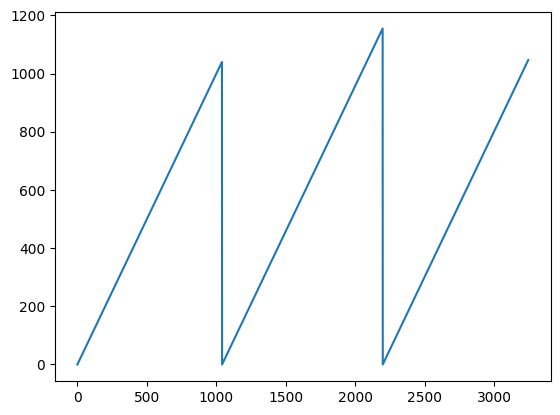

In [333]:
plt.plot(reval[2][:,0])

In [326]:
reval[2].shape

(2089, 7)

In [342]:
reval[0][:,0]

array([401.25290972, 669.8802407 , 158.96741383, 477.78307231,
       977.77518369, 680.89986589,  73.64974767, 862.84853376,
       259.57579134, 889.22800546])

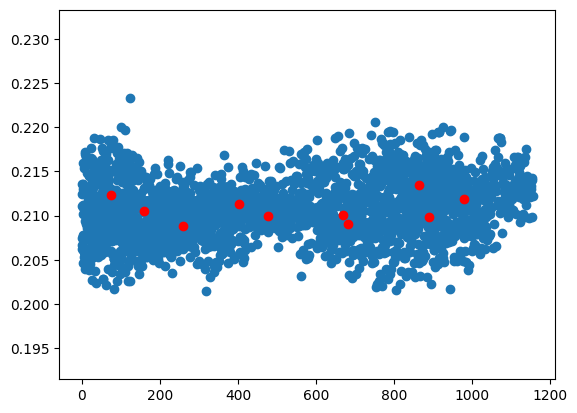

In [343]:
plot_element = 2

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1)
axes.scatter(reval[2][:,0],reval[2][:,2])
axes.scatter(reval[0][:,0],reval[0][:,2], color='red')

In [276]:
dats_list = [calc_x_y_array(augment_data(frame)) for frame in frame_list]


In [286]:
pd_list = [pd.DataFrame(e, columns=["x_a", "y_a", "Ft", "ang", "mag", "Fxt", "Fyt", "Fzt"]) for e in dats_list]

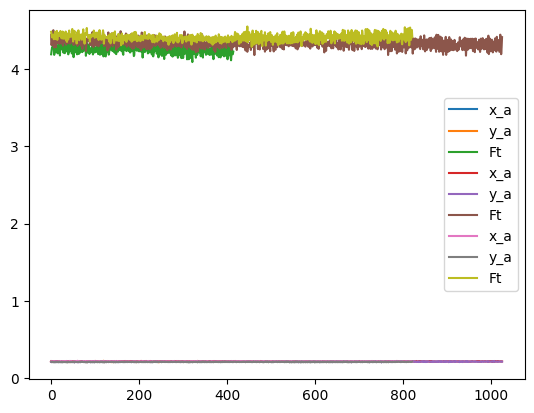

In [303]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1)
for p in pd_list:
    p.plot(ax = axes,y = ['x_a','y_a','Ft'])

In [301]:
fig.show()

/tmp/ipykernel_1264916/89474557.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [345]:
reval[0].shape

(10, 7)

In [346]:
ms = reval[0]

In [350]:
ms[[5,6],1:3]

array([[0.21009911, 0.20899859],
       [0.21396785, 0.21235379]])

In [351]:
ms[5:7, 1:3]

array([[0.21009911, 0.20899859],
       [0.21396785, 0.21235379]])

In [1]:
import yaml

In [2]:
a = {"a": 1}
b = {"b": 2}

a.update(b)

In [3]:
a

{'a': 1, 'b': 2}

In [7]:
from rich import print

In [13]:
def build_single_frame_dict(name:str, pl:list, ol:list,parent:str):
    o = {"orientation": {k:v for k,v in zip('wxyz',ol)}}
    s = {"parent":parent, "style": "none"}
    p = {"position": {k:v for k,v in zip('xyz',pl)}}
    dg = {name: {**o, **s, **p}}
    return dg


names = ["box_rotated", "cable_align_left_down"]

fd = {"frames":[build_single_frame_dict(n,[0,0,0],[0,0,0,0],'test') for n in names]}


In [14]:
print(yaml.dump(fd))

frames:
- box_rotated:
    orientation:
      w: 0
      x: 0
      y: 0
      z: 0
    parent: test
    position:
      x: 0
      y: 0
      z: 0
    style: none
- cable_align_left_down:
    orientation:
      w: 0
      x: 0
      y: 0
      z: 0
    parent: test
    position:
      x: 0
      y: 0
      z: 0
    style: none